# Single Object Localization with PyTorch

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-wrccx8y2
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-wrccx8y2
  Resolved https://github.com/albumentations-team/albumentations to commit fe249f572df79a56259f7b878a3951d79fd64b92
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.0 MB/s eta 0:00:00


# Download Dataset

original author of the dataset :
https://github.com/parth1620/object-localization-dataset.git

In [ ]:
!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 32.94 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# Import Packages

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

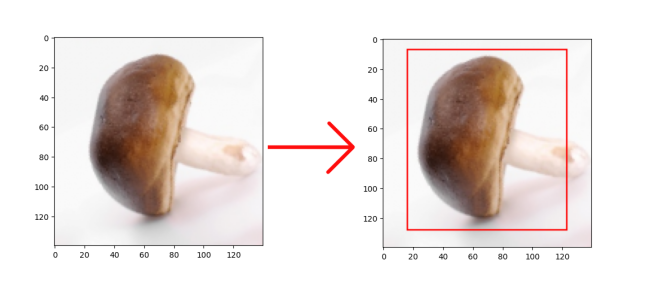

# Configurations

In [ ]:
csv_file = '/content/object-localization-dataset/train.csv'
data_dir = '/content/object-localization-dataset/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 140
batch_size = 16
epochs = 40

lr = 0.001

model_name = 'efficientnet_b0'

In [ ]:
df = pd.read_csv(csv_file)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

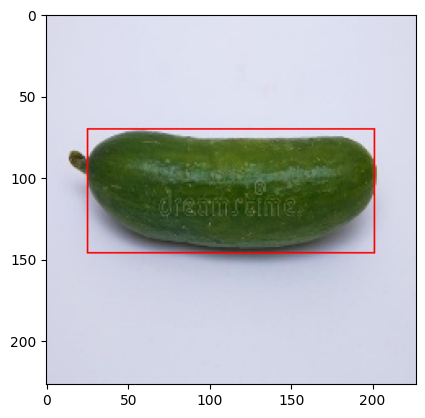

In [ ]:
row = df.iloc[20]
img = cv2.imread(data_dir + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
p1 = (row.xmin, row.ymin)
p2 = (row.xmax, row.ymax)
box = cv2.rectangle(img, p1, p2, (255,0,0), 1)
plt.imshow(img)


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.20)

# Define Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

test_augs = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):
  """
  Custom dataset class for object localization tasks.
  Inherits from the torch.utils.data.Dataset class to provide data loading and handling for PyTorch models.
  """

  def __init__(self, df, augmentations = None):
    """
    Initialize the dataset.

    Args:
      df (pandas.DataFrame): DataFrame containing object bounding box annotations.
      augmentations (albumentations.Compose, optional): Augmentations to apply to the images and bounding boxes. Defaults to None.
    """

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    """
    Return the number of samples in the dataset.
    """
    return len(self.df)

  def __getitem__(self, idx):
    """
    Special method called when indexing the dataset object (`obj[idx]`).

    Retrieves and processes a single sample (image and bounding box) from the dataset at the given index.

    Args:
      idx (int): Index of the sample to retrieve.

    Returns:
      tuple: A tuple containing the processed image (PyTorch tensor) and bounding box (PyTorch tensor).
    """

    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    # Load image and bounding box coordinates from the DataFrame
    img_path = data_dir + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image=img, bboxes=bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    # Convert image to PyTorch tensor and normalize
    img = torch.from_numpy(img).permute(2,0,1) / 255.0  #(h,w,c) -> (c,h,w)
    bbox = torch.Tensor(bbox)

    return img, bbox

In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(test_df, test_augs)

In [ ]:
print("Total examples in trainset : ", len(trainset))
print("Total examples in validset : ", len(validset))

Total examples in trainset :  148
Total examples in validset :  38


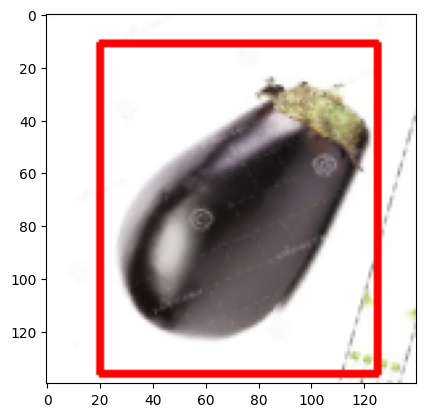

In [ ]:
img, bbox = trainset[20]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size = batch_size, shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(model_name, pretrained=True, num_classes=4)

  def forward(self, images, gt_bboxes=None):
    """
    Performs a forward pass through the model for either prediction or training.

    Args:
      images: A batch of input images represented as a torch tensor of shape (batch_size, channels, height, width).
      gt_bboxes: Ground truth bounding boxes for training, represented as a torch tensor of shape (batch_size, num_objects, 4)
                 where each entry is (xmin, ymin, xmax, ymax). Defaults to None.

    Returns:
      A tuple containing:
        - predicted_bboxes: A torch tensor of shape (batch_size, 4) containing predicted bounding box coordinates.
        - loss: (optional) A scalar torch tensor representing the training loss if `gt_bboxes` is provided, otherwise None.
    """

    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes


In [ ]:
model = ObjLocModel()
model.to(device);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
random_img = torch.rand(1, 3, 140, 140).to(device)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() # Dropout on

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(device), gt_bboxes.to(device)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()  # Dropout off

  with torch.no_grad():   # Disable gradient calculation
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(device), gt_bboxes.to(device)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

  return total_loss / len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
best_valid_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss

  print(f"Epoch : {i + 1}  train_loss : {train_loss}  valid_loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 1  train_loss : 5423.755639648438  valid_loss : 3608.414306640625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2  train_loss : 2091.20908203125  valid_loss : 1688.8697509765625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3  train_loss : 1154.336004638672  valid_loss : 222.43905131022134


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4  train_loss : 773.2748168945312  valid_loss : 268.39788309733075


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5  train_loss : 551.4071258544922  valid_loss : 265.4407653808594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6  train_loss : 451.32091369628904  valid_loss : 201.57251993815103


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7  train_loss : 322.8531097412109  valid_loss : 217.1045125325521


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8  train_loss : 274.0902694702148  valid_loss : 194.90593465169272


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9  train_loss : 191.47860717773438  valid_loss : 167.59821573893228


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10  train_loss : 143.70113296508788  valid_loss : 162.2786610921224


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11  train_loss : 131.7657341003418  valid_loss : 146.8238983154297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12  train_loss : 111.77578964233399  valid_loss : 122.29361470540364


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13  train_loss : 115.07596969604492  valid_loss : 122.19887288411458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14  train_loss : 116.55025825500488  valid_loss : 113.0954106648763


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15  train_loss : 86.95193748474121  valid_loss : 102.46705627441406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16  train_loss : 109.42184066772461  valid_loss : 137.22911071777344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17  train_loss : 105.95530204772949  valid_loss : 110.54288228352864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18  train_loss : 90.00863189697266  valid_loss : 96.54426574707031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19  train_loss : 70.0185489654541  valid_loss : 109.08057657877605


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20  train_loss : 75.3243251800537  valid_loss : 56.594578425089516


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21  train_loss : 58.360877990722656  valid_loss : 63.93734995524088


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22  train_loss : 72.36674499511719  valid_loss : 86.55033620198567


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23  train_loss : 89.42515335083007  valid_loss : 66.93261082967122


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24  train_loss : 62.28536243438721  valid_loss : 115.0925064086914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25  train_loss : 64.64024391174317  valid_loss : 57.694140116373696


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26  train_loss : 79.22148208618164  valid_loss : 59.19633483886719


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27  train_loss : 54.562086296081546  valid_loss : 65.40133158365886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28  train_loss : 52.24823913574219  valid_loss : 100.63141123453777


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29  train_loss : 50.18819236755371  valid_loss : 60.373669942220054


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30  train_loss : 54.08437538146973  valid_loss : 56.60275522867838


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31  train_loss : 51.88980140686035  valid_loss : 50.03693517049154


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32  train_loss : 56.44074974060059  valid_loss : 97.18917592366536


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33  train_loss : 46.16611194610596  valid_loss : 80.58239237467448


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34  train_loss : 44.66143856048584  valid_loss : 53.396612803141274


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35  train_loss : 40.129354095458986  valid_loss : 61.145286560058594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36  train_loss : 49.47862510681152  valid_loss : 62.68301137288412


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37  train_loss : 42.051394081115724  valid_loss : 90.56771596272786


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38  train_loss : 43.91649208068848  valid_loss : 53.563035329182945


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39  train_loss : 43.992085456848145  valid_loss : 67.26746622721355


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40  train_loss : 37.27542304992676  valid_loss : 69.15916315714519


#Inference

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

image, gt_bbox = validset[2]
image = image.unsqueeze(0).to(device)
out_bbox = model(image)


<ipython-input-26-4ff187a5e45a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


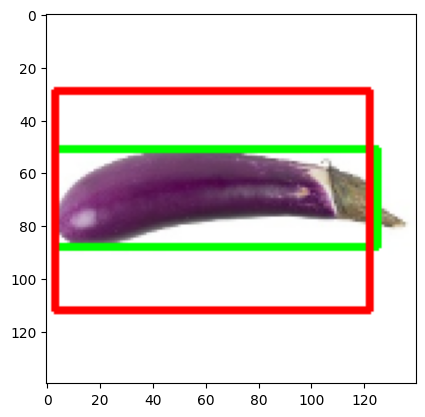

In [ ]:
# Compare ground truth and output bounding boxes. Output in red

xmin, ymin, xmax, ymax = gt_bbox

pt1 = (int(xmin), int(ymin))

pt2 = (int(xmax), int(ymax))

out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

out_pt1 = (int(out_xmin), int(out_ymin))

out_pt2 = (int(out_xmax), int(out_ymax))

img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
img = cv2.rectangle(img, out_pt1, out_pt2,(255,0,0),2)

plt.imshow(img)